In [4]:
import pandas as pd
import numpy as np
from py_pcha import PCHA

df = pd.read_csv("E:/Opossum_Paper/Figure 3/opossum_triangle_integrated.csv")
df = df.loc[df["method"] == "Stereo-seq"]
X = np.array(df[["X", "Y"]])

XC, S, C, SSE, varexpl = PCHA(X.T, noc=3, delta=0.1)

In [16]:
XC_r = XC[:, [2, 0, 1]]

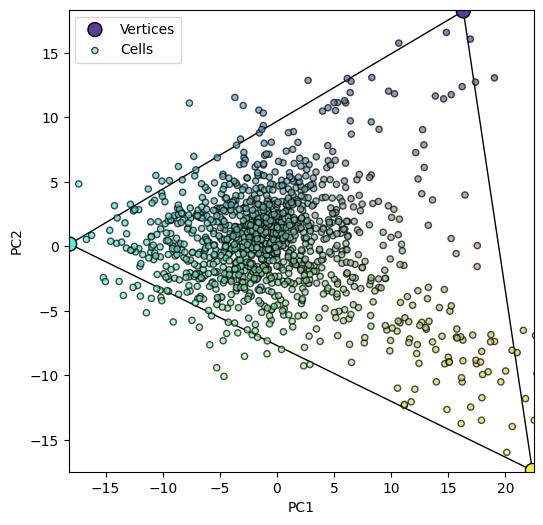

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import pandas as pd
from scipy.spatial.distance import cdist

# Define three vertices of the triangle in PC space
cells = np.array(X)  # (N, 2) - N cells with 2D coordinates (PC1, PC2)
vertices = np.array(XC_r.T)  # (3, 2) - Three vertices defining the triangle
colors = np.array([[0.36863, 0.23529, 0.60000], [0.31764706, 0.94117647, 0.89019608], [1.        , 0.95294118, 0.18823529]])  # (3, 3) - RGB colors for each vertex

# Function to compute barycentric coordinates
def barycentric_coords(triangle, points):
    A, B, C = triangle[0], triangle[1], triangle[2]  # Each (2,) - Extract vertices
    v0, v1 = B - A, C - A  # (2,) - Basis vectors of the triangle
    v2 = points - A  # (N, 2) - Vectors from A to each cell
    
    d00 = np.dot(v0, v0)  # Scalar - Dot product of v0 with itself
    d01 = np.dot(v0, v1)  # Scalar - Dot product of v0 with v1
    d11 = np.dot(v1, v1)  # Scalar - Dot product of v1 with itself
    d20 = np.sum(v2 * v0, axis=1)  # (N,) - Dot product of v2 with v0
    d21 = np.sum(v2 * v1, axis=1)  # (N,) - Dot product of v2 with v1
    
    denom = d00 * d11 - d01 * d01  # Scalar - Determinant of the matrix
    v = (d11 * d20 - d01 * d21) / denom  # (N,) - Barycentric coordinate for vertex B
    w = (d00 * d21 - d01 * d20) / denom  # (N,) - Barycentric coordinate for vertex C
    u = 1 - v - w  # (N,) - Barycentric coordinate for vertex A
    
    return np.vstack((u, v, w)).T  # (N, 3) - Barycentric coordinates for all cells

# Ensure correct shape for vertices
if vertices.shape[1] != 2:
    vertices = vertices.T  # Ensure (3,2) shape

# Compute barycentric coordinates for each cell
bary_coords = barycentric_coords(vertices, cells)  # (N, 3)

# Ensure all barycentric coordinates are within valid range
bary_coords = np.clip(bary_coords, 0, 1)  # Clamps values to [0,1]

# Compute color for each cell by mixing vertex colors
cell_colors = np.dot(bary_coords, colors)  # (N, 3) - Weighted RGB values

# Ensure final computed colors are within valid RGB range [0,1]
cell_colors = np.clip(cell_colors, 0, 1)
cell_names = df["cell"]  # Generate cell names
rgb_df = pd.DataFrame(cell_colors, columns=["R", "G", "B"], index=cell_names)

# Calculate distances from each cell to each vertex
distances = cdist(cells, vertices, metric='euclidean')  # (N, 3) - Distance from cells to vertices

# Add distances to the RGB DataFrame
for i, vertex_label in enumerate(['Vertex_C', 'Vertex_A', 'Vertex_B']):
    rgb_df[f'Distance_to_{vertex_label}'] = distances[:, i]

# Save RGB triplets with cell names to CSV
rgb_df.to_csv("E:/Opossum_Paper/Figure 3/opossum_integrated_PC_colors.csv")

# Plot the triangular colormap
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(np.min(vertices[:, 0]) - 0.1, np.max(vertices[:, 0]) + 0.1)
ax.set_ylim(np.min(vertices[:, 1]) - 0.1, np.max(vertices[:, 1]) + 0.1)
ax.triplot(vertices[:, 0], vertices[:, 1], [[0, 1, 2]], color='k', linewidth=1)
ax.scatter(vertices[:, 0], vertices[:, 1], c=colors, edgecolor='black', s=100, label='Vertices')
ax.scatter(cells[:, 0], cells[:, 1], c=cell_colors, s=20, edgecolor='k', alpha=0.7, label='Cells')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()
plt.show()

In [18]:
XC_r

matrix([[ 16.31175761, -18.14317413,  22.35570761],
        [ 18.23171512,   0.17690231, -17.35573216]])

In [52]:
df

,cell,method,X,Y
0,P38_1a_AAACCCAAGTGACACG-1-P38_1a-P38,snRNA-seq,-21.402286,6.209378
1,P38_1a_AAACGCTAGTACAGAT-1-P38_1a-P38,snRNA-seq,18.518520,1.366320
2,P38_1a_AAACGCTAGTGAGGCT-1-P38_1a-P38,snRNA-seq,14.307829,9.647125
3,P38_1a_AAACGCTGTATGGAAT-1-P38_1a-P38,snRNA-seq,11.848202,-6.903838
4,P38_1a_AAAGAACAGTAGTCCT-1-P38_1a-P38,snRNA-seq,15.520991,-0.429963
...,...,...,...,...
8201,31413390814895,Stereo-seq,-12.533483,2.179898
8202,30842160164381,Stereo-seq,-1.972462,2.627258
8203,30799210491495,Stereo-seq,-12.856334,5.492263
8204,32238024535614,Stereo-seq,7.942392,7.010218
